In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os

In [2]:
datapath = r'C:\Users\Jasmine kaur\Downloads\archive\crop_part1'
image_size = 64
images, ages, genders = [], [], []

for file in os.listdir(datapath):
    if not file.endswith('.jpg'):  
        continue

    try:
        age = int(file.split('_')[0])
        gender = int(file.split('_')[1])
        img_path = os.path.join(datapath, file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping unreadable image: {file}")
            continue

        img = cv2.resize(img, (image_size, image_size))
        images.append(img)
        ages.append(age)
        genders.append(gender)

    except Exception as e:
        print(f"Skipping file {file} due to error: {e}")
        continue

print(f" Loaded {len(images)} images successfully.")


 Loaded 9780 images successfully.


In [3]:
print(len(ages))

9780


In [5]:
x = np.array(images)/ 255.0 

max_age = 100
y_age = np.array(ages) / max_age

y_gender = np.array(genders)

In [6]:
x_train, x_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    x, y_age, y_gender, test_size=0.2, random_state=42)


In [8]:
import tensorflow as tf

def preprocess(x, y_age, y_gender):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.2)
    x = tf.image.random_contrast(x, lower=0.8, upper=1.2)
    return x, {'age_output': y_age, 'gender_output': y_gender}


In [9]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_age_train, y_gender_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_age_test, y_gender_test))
val_ds = val_ds.map(lambda x, y1, y2: (x, {'age_output': y1, 'gender_output': y2}))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [10]:
input_layer = Input(shape=(image_size, image_size, 3))

x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  
x = Dropout(0.5)(x)





In [11]:
age_output = Dense(1, name="age_output")(x)

gender_output = Dense(1, activation='sigmoid', name="gender_output")(x)


In [12]:
model = Model(inputs=input_layer, outputs=[age_output, gender_output])
model.compile(
    optimizer='adam',
    loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
    loss_weights={'age_output': 2.0, 'gender_output': 1.0}
)


In [13]:

early_stop = EarlyStopping(monitor='val_age_output_loss', patience=5, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_age_output_loss', factor=0.5, patience=3, mode='min')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)




Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - age_output_loss: 1.6569 - gender_output_loss: 0.8434 - loss: 4.1573 - val_age_output_loss: 0.0751 - val_gender_output_loss: 0.6923 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - age_output_loss: 0.0813 - gender_output_loss: 0.6640 - loss: 0.8267 - val_age_output_loss: 0.0550 - val_gender_output_loss: 0.6128 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - age_output_loss: 0.0628 - gender_output_loss: 0.6235 - loss: 0.7492 - val_age_output_loss: 0.0429 - val_gender_output_loss: 0.5495 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - age_output_loss: 0.0579 - gender_output_loss: 0.5785 - loss: 0.6942 - val_age_output_loss: 0.0445 - val_gender_output_loss: 0.4991 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - age_output_loss: 0.0563

In [14]:

eva = model.evaluate(x_test, {'age_output': y_age_test, 'gender_output': y_gender_test})
for value in eva:
    print(value)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - age_output_loss: 0.0411 - gender_output_loss: 0.5380 - loss: 0.6204
0.6379204392433167
0.04285619035363197
0.5495219826698303


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


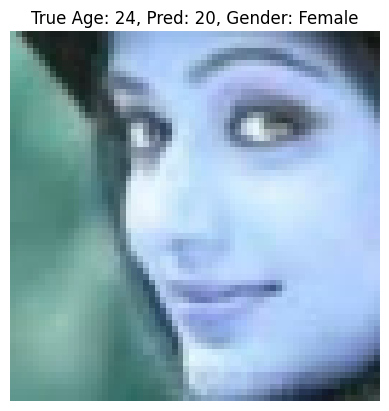

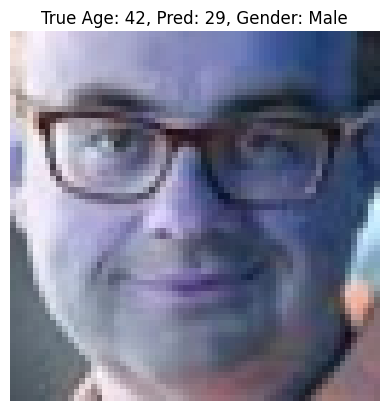

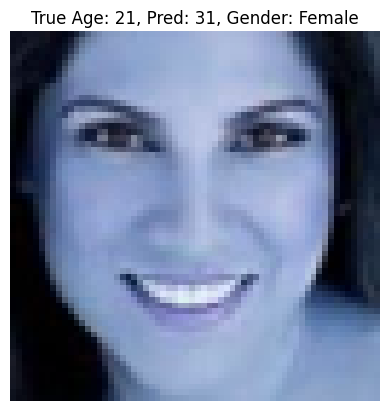

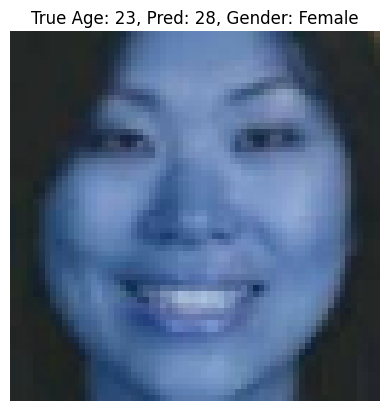

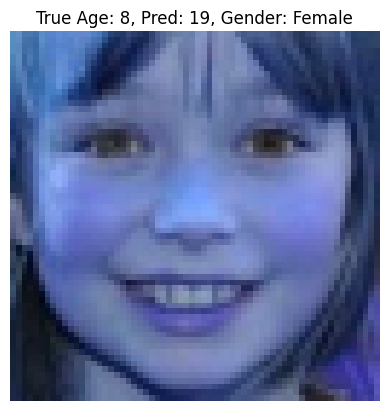

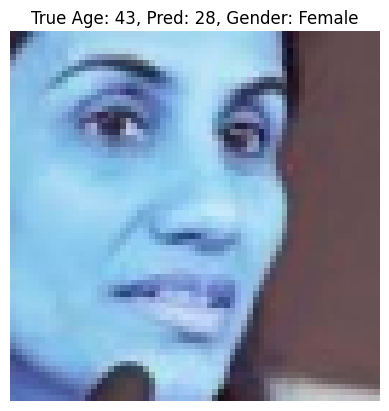

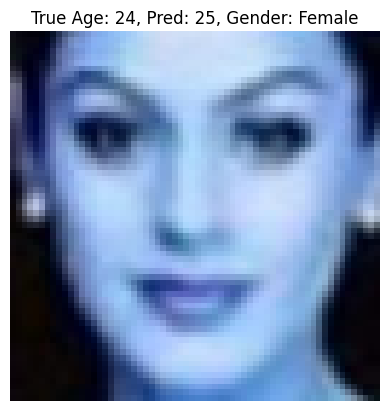

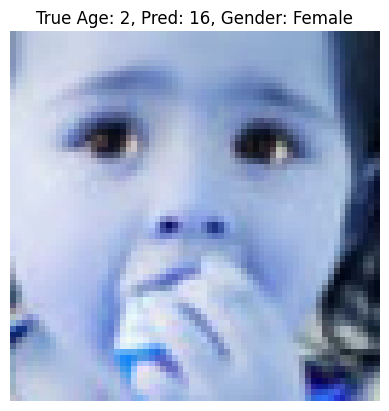

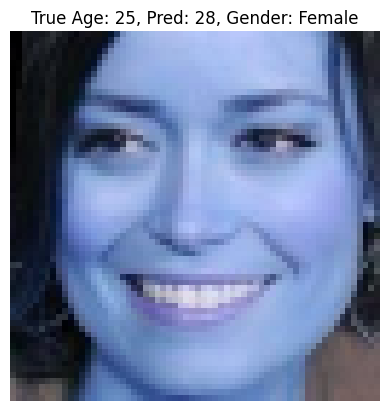

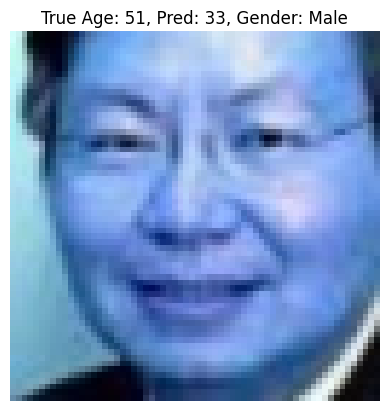

In [16]:
import random

random_indices = random.sample(range(len(x_test)), 10)

pred_age, pred_gender = model.predict(x_test[random_indices])

for i, idx in enumerate(random_indices):
    plt.imshow(x_test[idx])
    true_age = int(round(y_age_test[idx] * max_age))       
    pred_age_original = int(round(pred_age[i][0] * max_age)) 
    plt.title(f"True Age: {true_age}, Pred: {pred_age_original}, Gender: {'Male' if pred_gender[i] < 0.5 else 'Female'}")
    plt.axis('off')
    plt.show()



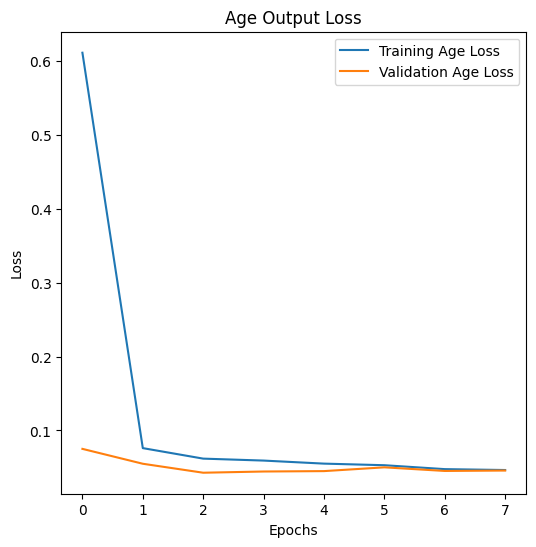

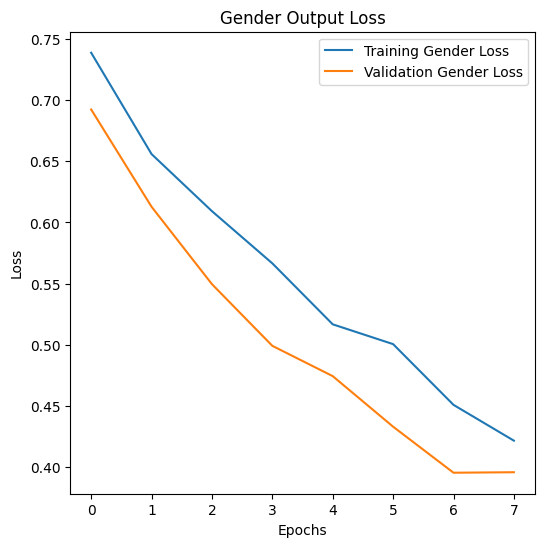

In [17]:
metrics = history.history

# Plot age output loss
plt.figure(figsize=(6, 6))
plt.plot(metrics['age_output_loss'], label='Training Age Loss')
plt.plot(metrics['val_age_output_loss'], label='Validation Age Loss')
plt.title('Age Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot gender output loss
plt.figure(figsize=(6, 6))
plt.plot(metrics['gender_output_loss'], label='Training Gender Loss')
plt.plot(metrics['val_gender_output_loss'], label='Validation Gender Loss')
plt.title('Gender Output Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

